In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 18
%matplotlib inline

N_FOLDS = 5
MAX_EVALS = 5

In [3]:
features = pd.read_csv('D:\\statistics\\machine learning in action\\Kaggle-Home-Credit-Default-Risk-Solution-master\\home-credit-default-risk\\application_train.csv')

features = features.sample(n = 16000, random_state = 42)
features = features.select_dtypes('number')
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
features = features.drop(columns = ['TARGET', 'SK_ID_CURR'])

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 6000, random_state = 42)

print('Train shape: ', train_features.shape)
print('Test shape: ', test_features.shape)

train_features.head()

Train shape:  (10000, 104)
Test shape:  (6000, 104)


,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
99825,2,99000.0,562491.0,27189.0,454500.0,0.007330,-10901,-603,-574.0,-3572,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
208378,0,157500.0,677664.0,34731.0,585000.0,0.024610,-12091,-1358,-2918.0,-3715,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,6.0
1309,2,112500.0,864000.0,25393.5,864000.0,0.028663,-11922,-1868,-1465.0,-4580,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
172223,1,63000.0,180000.0,9000.0,180000.0,0.020246,-14570,-7753,-5007.0,-4719,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
258157,0,202500.0,1193580.0,42417.0,855000.0,0.020713,-20925,-1049,-3149.0,-4437,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [4]:
model = lgb.LGBMClassifier(random_state=50)

# Training set
train_set = lgb.Dataset(train_features, label = train_labels)
test_set = lgb.Dataset(test_features, label = test_labels)

In [5]:
hyperparameters = model.get_params()

del hyperparameters['n_estimators']

cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, metrics = 'auc', 
           early_stopping_rounds = 100, verbose_eval = False, seed = 42)
best = cv_results['auc-mean'][-1]
best_std = cv_results['auc-stdv'][-1]

print('The maximium ROC AUC in cross validation was {:.5f} with std of {:.5f}.'.format(best, best_std))
print('The ideal number of iterations was {}.'.format(len(cv_results['auc-mean'])))

c:\python37\lib\site-packages\lightgbm\basic.py:741: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


The maximium ROC AUC in cross validation was 0.70867 with std of 0.02098.
The ideal number of iterations was 33.


In [6]:
print(hyperparameters)

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 50, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': True, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [7]:
model.n_estimators = len(cv_results['auc-mean'])

model.fit(train_features, train_labels)
preds = model.predict_proba(test_features)[:, 1]
baseline_auc = roc_auc_score(test_labels, preds)

print('The baseline model scores {:.5f} ROC AUC on the test set.'.format(baseline_auc))

The baseline model scores 0.71466 ROC AUC on the test set.


In [20]:
import csv
from hyperopt import STATUS_OK
from timeit import default_timer as timer

def objective(hyperparameters):    
    global ITERATION    
    ITERATION += 1

    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)    
    # Extract the boosting type and subsample to top level keys
    hyperparameters['boosting_type'] = hyperparameters['boosting_type']['boosting_type']
    hyperparameters['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])
    start = timer()
    if hyperparameters['boosting_type']=='dart':
        cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        metrics = 'auc', seed = 50)
    else:        
        cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 10000, nfold = N_FOLDS, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)
    run_time = timer() - start
    best_score = cv_results['auc-mean'][-1]
    loss = 1 - best_score
    n_estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = n_estimators

    # Write to the csv file ('a' means append)
    of_connection = open(OUT_FILE, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, hyperparameters, ITERATION, run_time, best_score])
    of_connection.close()

    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

In [10]:
from hyperopt import hp
from hyperopt.pyll.stochastic import sample

In [11]:
learning_rate = {'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2))}

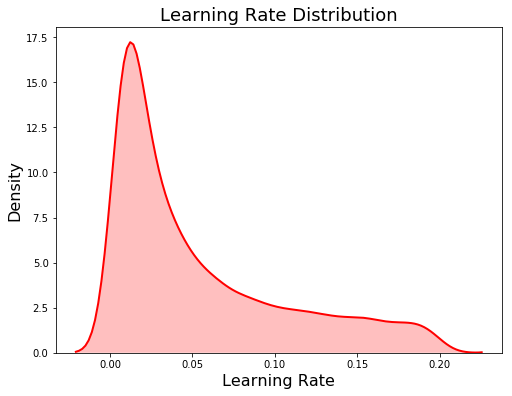

In [12]:
learning_rate_dist = []

# Draw 10000 samples from the learning rate domain
for _ in range(10000):
    learning_rate_dist.append(sample(learning_rate)['learning_rate'])
    
plt.figure(figsize = (8, 6))
sns.kdeplot(learning_rate_dist, color = 'red', linewidth = 2, shade = True);
plt.title('Learning Rate Distribution', size = 18); plt.xlabel('Learning Rate', size = 16); plt.ylabel('Density', size = 16);

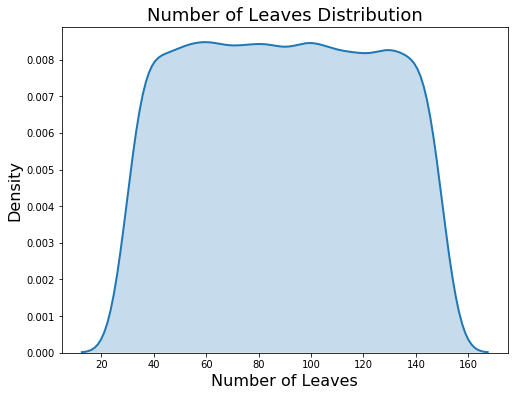

In [13]:
num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
num_leaves_dist = []

# Sample 10000 times from the number of leaves distribution
for _ in range(10000):
    num_leaves_dist.append(sample(num_leaves)['num_leaves'])
    
# kdeplot
plt.figure(figsize = (8, 6))
sns.kdeplot(num_leaves_dist, linewidth = 2, shade = True);
plt.title('Number of Leaves Distribution', size = 18); plt.xlabel('Number of Leaves', size = 16); plt.ylabel('Density', size = 16);

In [14]:
boosting_type = {'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}])}

# Draw a sample
hyperparams = sample(boosting_type)
hyperparams

{'boosting_type': {'boosting_type': 'dart', 'subsample': 0.8074601384599798}}

In [15]:
subsample = hyperparams['boosting_type'].get('subsample', 1.0)

hyperparams['boosting_type'] = hyperparams['boosting_type']['boosting_type']
hyperparams['subsample'] = subsample

hyperparams

{'boosting_type': 'dart', 'subsample': 0.8074601384599798}

In [16]:
space = {
    'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'is_unbalance': hp.choice('is_unbalance', [True, False]),
}

In [19]:
from hyperopt import tpe

# Create the algorithm
tpe_algorithm = tpe.suggest
from hyperopt import Trials

# Record results
trials = Trials()

In [41]:
OUT_FILE = 'bayes_test.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

ITERATION = 0

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

In [42]:
from hyperopt import fmin

In [43]:
global  ITERATION

ITERATION = 0

# Run optimization
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

best

 50%|████████████████████████████████████████████████████████████████████████                                                                        | 1/2 [00:02<00:02,  2.46s/it, best loss: 0.2731175104355478]


KeyboardInterrupt: 

In [44]:
trials_dict = sorted(trials.results, key = lambda x: x['loss'])
trials_dict[:1]

KeyError: 'loss'

In [ ]:
results = pd.read_csv(OUT_FILE)

In [39]:
import ast

def evaluate(results, name):
    """Evaluate model on test data using hyperparameters in results
       Return dataframe of hyperparameters"""
    
    new_results = results.copy()
    # String to dictionary
    new_results['hyperparameters'] = new_results['hyperparameters'].map(ast.literal_eval)
    
    # Sort with best values on top
    new_results = new_results.sort_values('score', ascending = False).reset_index(drop = True)
    
    # Print out cross validation high score
    print('The highest cross validation score from {} was {:.5f} found on iteration {}.'.format(name, new_results.loc[0, 'score'], new_results.loc[0, 'iteration']))
    
    # Use best hyperparameters to create a model
    hyperparameters = new_results.loc[0, 'hyperparameters']
    model = lgb.LGBMClassifier(**hyperparameters)
    
    # Train and make predictions
    model.fit(train_features, train_labels)
    preds = model.predict_proba(test_features)[:, 1]
    
    print('ROC AUC from {} on test data = {:.5f}.'.format(name, roc_auc_score(test_labels, preds)))
    
    # Create dataframe of hyperparameters
    hyp_df = pd.DataFrame(columns = list(new_results.loc[0, 'hyperparameters'].keys()))

    # Iterate through each set of hyperparameters that were evaluated
    for i, hyp in enumerate(new_results['hyperparameters']):
        hyp_df = hyp_df.append(pd.DataFrame(hyp, index = [0]), 
                               ignore_index = True)
        
    # Put the iteration and score in the hyperparameter dataframe
    hyp_df['iteration'] = new_results['iteration']
    hyp_df['score'] = new_results['score']
    
    return hyp_df

In [36]:
print(trials.results)

[{'loss': 0.3191695011516741, 'hyperparameters': {'boosting_type': 'gbdt', 'colsample_bytree': 0.9599563311935736, 'is_unbalance': True, 'learning_rate': 0.4368545396133974, 'min_child_samples': 70, 'num_leaves': 40, 'reg_alpha': 0.21637622388686328, 'reg_lambda': 0.06368510677560124, 'subsample_for_bin': 60000, 'subsample': 0.9572979550374721, 'n_estimators': 3}, 'iteration': 1, 'train_time': 2.882722975999968, 'status': 'ok'}, {'loss': 0.2790800034230716, 'hyperparameters': {'boosting_type': 'gbdt', 'colsample_bytree': 0.9463837308757719, 'is_unbalance': True, 'learning_rate': 0.044077624123153206, 'min_child_samples': 330, 'num_leaves': 90, 'reg_alpha': 0.8036151112747358, 'reg_lambda': 0.06880798818698441, 'subsample_for_bin': 80000, 'subsample': 0.9183153204296206, 'n_estimators': 64}, 'iteration': 2, 'train_time': 2.3162412829997265, 'status': 'ok'}, {'loss': 0.2801006423308098, 'hyperparameters': {'boosting_type': 'goss', 'colsample_bytree': 0.6439088034443311, 'is_unbalance': T

In [40]:
bayes_results = evaluate(trials.results, name = 'Bayesian')
bayes_results

TypeError: list indices must be integers or slices, not str

In [33]:
MAX_EVALS = 10

# Continue training
best = fmin(fn = objective, space = space, algo = tpe.suggest, trials = trials,
            max_evals = MAX_EVALS)

 40%|████████████████████████████████████████████████████████▊                                                                                     | 2/5 [07:06<06:24, 128.33s/it, best loss: 0.27744290533622706]


KeyboardInterrupt: 

In [ ]:
MAX_EVALS = 1000

# Create a new file and open a connection
OUT_FILE = 'bayesian_trials_1000.csv'
of_connection = open(OUT_FILE, 'w')
writer = csv.writer(of_connection)

# Write column names
headers = ['loss', 'hyperparameters', 'iteration', 'runtime', 'score']
writer.writerow(headers)
of_connection.close()

# # Record results
trials = Trials()

global ITERATION

ITERATION = 0 

best = fmin(fn = objective, space = space, algo = tpe.suggest,
            trials = trials, max_evals = MAX_EVALS)

# Sort the trials with lowest loss (highest AUC) first
trials_dict = sorted(trials.results, key = lambda x: x['loss'])

print('Finished, best results')
print(trials_dict[:1])

# # Save the trial results
with open('trials.json', 'w') as f:
    f.write(json.dumps(trials_dict))

In [ ]:
bayes_results = pd.read_csv('../input/home-credit-model-tuning/bayesian_trials_1000.csv').sort_values('score', ascending = False).reset_index()
bayes_params = evaluate(bayes_results, name = 'Bayesian')

In [ ]:
best_bayes_params = bayes_params.iloc[bayes_params['score'].idxmax(), :].copy()

In [ ]:
train = pd.read_csv('../input/home-credit-simple-featuers/simple_features_train.csv')
test = pd.read_csv('../input/home-credit-simple-featuers/simple_features_test.csv')

# Extract the test ids and train labels
test_ids = test['SK_ID_CURR']
train_labels = np.array(train['TARGET'].astype(np.int32)).reshape((-1, ))

train = train.drop(columns = ['SK_ID_CURR', 'TARGET'])
test = test.drop(columns = ['SK_ID_CURR'])

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

In [ ]:
hyperparameters = dict(**bayes_results.loc[0, 'hyperparameters'])
del hyperparameters['n_estimators']

# Cross validation with n_folds and early stopping
cv_results = lgb.cv(hyperparameters, train_set,
                    num_boost_round = 10000, early_stopping_rounds = 100, 
                    metrics = 'auc', nfold = N_FOLDS)

print('The cross validation score on the full dataset for Bayesian optimization = {:.5f} with std: {:.5f}.'.format(
    cv_results['auc-mean'][-1], cv_results['auc-stdv'][-1]))
print('Number of estimators = {}.'.format(len(cv_results['auc-mean'])))

In [ ]:
model = lgb.LGBMClassifier(n_estimators = len(cv_results['auc-mean']), **hyperparameters)
model.fit(train, train_labels)

preds = model.predict_proba(test)[:, 1]

submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': preds})
submission.to_csv('submission_bayesian_optimization.csv', index = False)